In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import yfinance as yf
import datetime
import mplfinance as mplf
import plotly.graph_objects as go
import scipy.stats as stats
import pylab
import statsmodels.api as sm
warnings.filterwarnings('ignore')

In [2]:
#określenie początkowej i końcowej daty
startDate = datetime.datetime(2023, 1, 1)
endDate = datetime.datetime(2023, 3, 1)
#pobranie danych z yahoo finance (cena otwarcia, zamknięcia, najwyższa, najniższa)
data = yf.Ticker("META").history(start=startDate, end=endDate, interval="1d")[['Open', 'Close', 'High', 'Low']]
#utworzenie wykresu świecowego
fig = go.Figure(data=[go.Candlestick(x=data.index,
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'])])
fig.update_layout(title="Wykres świeciowy dla firmy META",
                  yaxis_title="Cena",
                  xaxis_title="Data",
                  xaxis_rangeslider_visible=False)
fig.update_xaxes(dtick="D1", tickformat="%d %b %Y", tickangle=90)



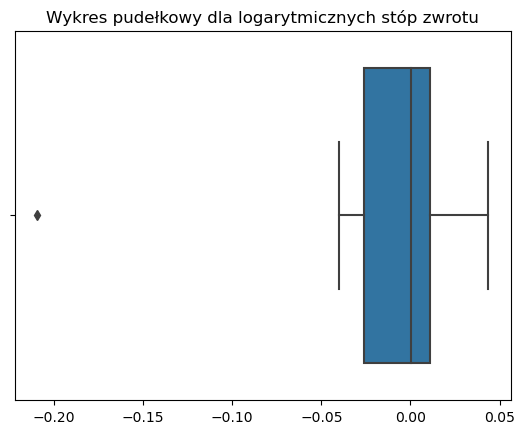

In [3]:
#obliczanie logarytmicznych stóp zwrotu
data['log_returns'] = np.log(data['Close']) - np.log(data['Close']).shift(-1)
#obliczenie statystyk opisowych dla logarytmicznych stóp zwrotu
log_returns_stats = data['log_returns'].describe(percentiles=[.01, .05, .95, .99])[1:]
#tworzenie wykresu pudełkowego dla logarytmicznych stóp zwrotu
sns.boxplot(data['log_returns'], orient='h')
plt.title("Wykres pudełkowy dla logarytmicznych stóp zwrotu")
plt.yticks([0], [''])
plt.show()

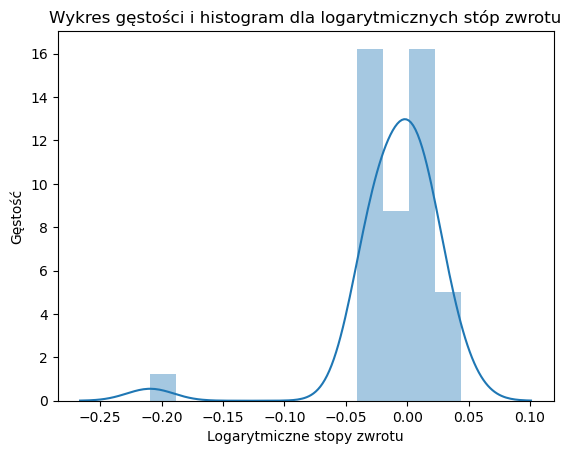

In [4]:
#stworzenie histogramu i wykresu gęstości dla logarytmicznych stóp zwrotu
sns.distplot(data['log_returns'], hist=True, kde=True).set(xlabel='Logarytmiczne stopy zwrotu',ylabel='Gęstość')
plt.title("Wykres gęstości i histogram dla logarytmicznych stóp zwrotu")
plt.show()

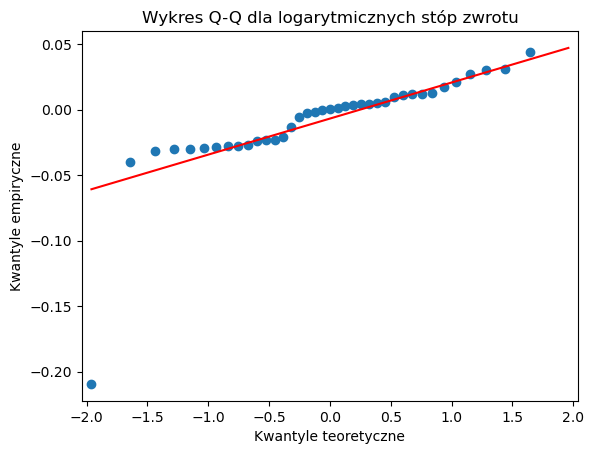

In [5]:
#stworzenie q-q plot dla logarytmicznych stóp zwrotu
sm.qqplot(data['log_returns'], line='q',xlabel='Kwantyle teoretyczne',ylabel='Kwantyle empiryczne')
plt.title("Wykres Q-Q dla logarytmicznych stóp zwrotu")
pylab.show()


In [6]:
#sprawdzenie z pomocą testu Shapiro-Wilka czy logarytmiczne stopy zwrotu mają rozkład normalny
#H0: dane mają rozkład normalny
#H1: dane nie mają rozkładu normalnego
shapiro_wilk = stats.shapiro(data['log_returns'].dropna())
print("P-value: ", shapiro_wilk[1])
if shapiro_wilk[1] < 0.05:
    print("P-value < 0.05 więc odrzucamy hipotezę zerową o normalności rozkładu logarytmicznych stóp zwrotu")
else:
    print("P-value >= 0.05 więc nie odrzucamy hipotezy zerowej o normalności rozkładu logarytmicznych stóp zwrotu")


P-value:  3.5362972994334996e-08
P-value < 0.05 więc odrzucamy hipotezę zerową o normalności rozkładu logarytmicznych stóp zwrotu


In [7]:
#sprawdzenie z pomocą testu Jarque-Bera czy logarytmiczne stopy zwrotu mają rozkład normalny
#H0: dane mają rozkład normalny
#H1: dane nie mają rozkładu normalnego
jarque_bera = stats.jarque_bera(data['log_returns'].dropna())
print("P-value: ", jarque_bera[1])
if jarque_bera[1] < 0.05:
    print("P-value < 0.05 więc odrzucamy hipotezę zerową o normalności rozkładu logarytmicznych stóp zwrotu")
else:
    print("P-value >= 0.05 więc nie odrzucamy hipotezy zerowej o normalności rozkładu logarytmicznych stóp zwrotu")

P-value:  1.1454720147749795e-102
P-value < 0.05 więc odrzucamy hipotezę zerową o normalności rozkładu logarytmicznych stóp zwrotu


In [8]:
#sprawdzenie z pomocą testu Ljung-Boxa czy występuje autokorelacja dla stóp zwrotu
#H0: nie występuje autokorelacja
#H1: występuje autokorelacja
ljung_box = sm.stats.acorr_ljungbox(data['log_returns'].dropna(), lags=[10], return_df=True)
if ljung_box["lb_pvalue"].values[0] < 0.05:
    print("P-value < 0.05 więc odrzucamy hipotezę zerową o braku autokorelacji dla stóp zwrotu")
else:
    print("P-value >= 0.05 więc nie odrzucamy hipotezy zerowej o braku autokorelacji dla stóp zwrotu")

P-value >= 0.05 więc nie odrzucamy hipotezy zerowej o braku autokorelacji dla stóp zwrotu


In [9]:
#sprawdzenie z pomocą testu Durbin-Watsona czy zmienne są niezależne
#H0: zmienne są niezależne
#H1: zmienne nie są niezależne
durbin_watson = sm.stats.durbin_watson(data['log_returns'].dropna())
if durbin_watson < 1.5 or durbin_watson > 2.5:
    print("Statystyka Durbin-Watsona wynosi: ", durbin_watson)
    print("Statystyka Durbin-Watsona nie należy do przedziału [1.5, 2.5] więc odrzucamy hipotezę zerową o niezależności zmiennych")
else:
    print("Statystyka Durbin-Watsona wynosi: ", durbin_watson)
    print("Statystyka Durbin-Watsona należy do przedziału [1.5, 2.5] więc nie odrzucamy hipotezy zerowej o niezależności zmiennych")

Statystyka Durbin-Watsona wynosi:  1.8532692258574819
Statystyka Durbin-Watsona należy do przedziału [1.5, 2.5] więc nie odrzucamy hipotezy zerowej o niezależności zmiennych


In [55]:
#obliczenie średniej i odchylenia standardowego stóp zwrotu
mean = data['log_returns'].mean()
std = data['log_returns'].std()
#stworzenie tabeli do porównania 
comparison = pd.DataFrame(columns=["returns"])
comparison["returns"] = [0]*11
comparison["normal_distribution"] = [0]*11
comparison["chebyshev_inequality"] = [0]*11
#uzupełnienie tabeli 
for i in range(1,11):
    #odsetkami stóp zwrotu w przedziale  (średnia - i*odchylenie standardowe; średnia + i*odchylenie standardowe)
    comparison["returns"][i] = len(data[(data['log_returns'] < mean+std*i) & (data['log_returns'] > mean-std*i)])/len(data)
    #analogicznymi odsetkami dla rozkładu normalnego
    comparison["normal_distribution"][i] = stats.norm.cdf(mean+std*i, mean, std) - stats.norm.cdf(mean-std*i, mean, std)
    #analogicznymi odsetkami dla nierówności Czebyszewa
    comparison["chebyshev_inequality"][i] = 1 - 1/(i**2)
comparison.drop(comparison.index[0], inplace=True)

print(comparison)
    

     returns  normal_distribution  chebyshev_inequality
1   0.897436             0.682689              0.000000
2   0.948718             0.954500              0.750000
3   0.948718             0.997300              0.888889
4   0.948718             0.999937              0.937500
5   0.948718             0.999999              0.960000
6   0.974359             1.000000              0.972222
7   0.974359             1.000000              0.979592
8   0.974359             1.000000              0.984375
9   0.974359             1.000000              0.987654
10  0.974359             1.000000              0.990000


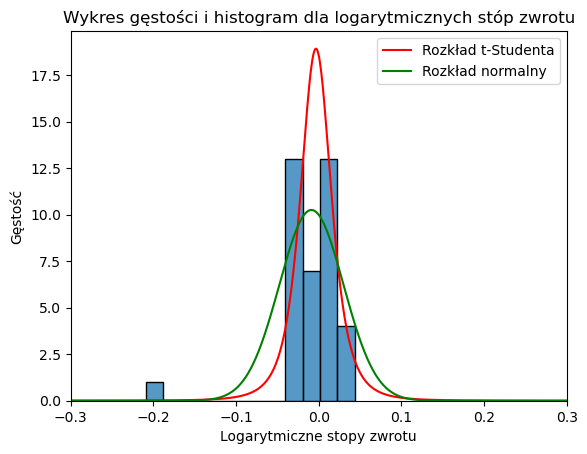

In [74]:
#estymuje najlepszy rozkład t-Studenta dla wektora stóp zwrotu i porównanie jego dopasowania z rozkładem normalnym o średniej i wariancji pochodzącymi z wektora stóp zwrotu

#estymacja parametrów rozkładu t-Studenta
params = stats.t.fit(data['log_returns'].dropna())
#estymacja parametrów rozkładu normalnego
params_normal = stats.norm.fit(data['log_returns'].dropna())

#stworzenie wektora wartości dla rozkładu t-Studenta i normalnego
x = np.linspace(data['log_returns'].min()-0.3, data['log_returns'].max()+0.3, 1000)
pdf_fitted_t = stats.t.pdf(x, *params)
pdf_fitted_normal = stats.norm.pdf(x, *params_normal)

#stworzenie histogramu i wykresu gęstości dla stóp zwrotu
sns.histplot(data['log_returns']).set(xlabel='Logarytmiczne stopy zwrotu',ylabel='Gęstość',xlim=(-0.3,0.3))
#dodanie do wykresu gęstości rozkładu t-Studenta i normalnego
plt.plot(x, pdf_fitted_t, color='r')
plt.plot(x, pdf_fitted_normal, color='g')
plt.legend(['Rozkład t-Studenta', 'Rozkład normalny'])
plt.title("Wykres gęstości i histogram dla logarytmicznych stóp zwrotu")
plt.show()

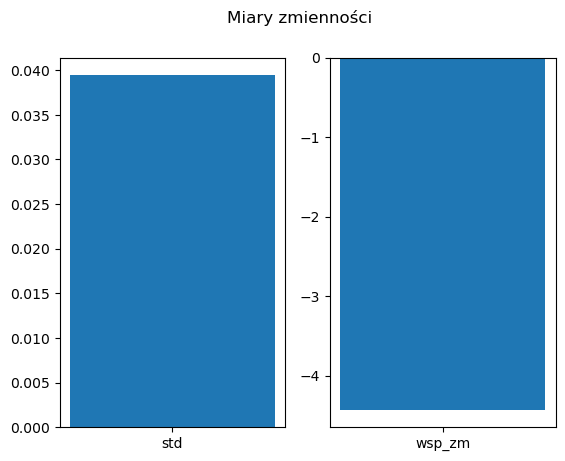

In [99]:
#wyznacza co najmniej dwie miary zmienności stóp zwrotu i przedstawia je na wykresie;
std = data['log_returns'].std()
mean = data['log_returns'].mean()
wsp_zm = std/mean
#przedstawienie miar zmienności na wykresach słupkowych
fig, axes = plt.subplots(1, 2)
fig.suptitle('Miary zmienności')
axes[0].bar(['std'], [std])
axes[1].bar(['wsp_zm'], [wsp_zm])
plt.show()